In [4]:
import csv

# Input and output file paths
input_file = 'mustard++_text.csv'  # Replace with your input file path
output_file = 'data.csv'  # Replace with your output file path

# Initialize a counter for rows with complete data
complete_data_count = 0

# Open the input CSV file with UTF-8 and output CSV file with UTF-8 with BOM encoding
with open(input_file, mode='r', newline='', encoding='utf-8') as infile, open(output_file, mode='w', newline='', encoding='utf-8-sig') as outfile:
    # Create a CSV reader and writer
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    # Get the header from the input file and write it to the output file
    header = next(reader)
    writer.writerow(header)
    
    # Iterate over each row in the input file
    pos=0
    neg=0
    for row in reader:
        if(row[6]=='0'):
            pos+=1
        elif(row[6]=='1'):
            neg+=1
        # Check if all columns in the row have data (no empty strings)
        if all(column.strip() for column in row):
            # Write the row to the output file if no columns are empty
            writer.writerow(row)
            # Increment the counter for rows with complete data
            complete_data_count += 1

print(f"Number of rows with complete data: {complete_data_count}")
print(f"Rows with complete data have been written to {output_file}.")
print(pos,neg)


Number of rows with complete data: 1202
Rows with complete data have been written to data.csv.
601 601


In [5]:
import os
import pandas as pd
import shutil

# Define the paths to your folders
folder1 = 'final_context_videos'  # Replace with the path to folder1
folder2 = 'final_utterance_videos'  # Replace with the path to folder2
output_folder1 = 'output_folder1'  # Replace with desired output path for unique files in folder1
output_folder2 = 'output_folder2'  # Replace with desired output path for unique files in folder2

# Create output folders if they don't exist
os.makedirs(output_folder1, exist_ok=True)
os.makedirs(output_folder2, exist_ok=True)

# Get a set of files from both folders
files_folder1 = set(os.listdir(folder1))
files_folder2 = set(os.listdir(folder2))

# Identify files unique to each folder
unique_to_folder1 = files_folder1 - files_folder2
unique_to_folder2 = files_folder2 - files_folder1


# Create CSV files listing the unique files
df_folder1 = pd.DataFrame(unique_to_folder1, columns=['Unique Files in Folder1'])
df_folder2 = pd.DataFrame(unique_to_folder2, columns=['Unique Files in Folder2'])

# Save the CSV files
df_folder1.to_csv(os.path.join(output_folder1, 'unique_files_folder1.csv'), index=False)
df_folder2.to_csv(os.path.join(output_folder2, 'unique_files_folder2.csv'), index=False)

print(f"Unique files in {folder1} have been copied to {output_folder1}.")
print(f"Unique files in {folder2} have been copied to {output_folder2}.")


Unique files in final_context_videos have been copied to output_folder1.
Unique files in final_utterance_videos have been copied to output_folder2.


Most Common Words: [('oh', 449), ('im', 376), ('know', 357), ('dont', 299), ('well', 296), ('like', 260), ('yeah', 251), ('thats', 213), ('youre', 204), ('okay', 204)]
count    6041.000000
mean        4.423936
std         3.135233
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        35.000000
Name: Sentence_Length, dtype: float64


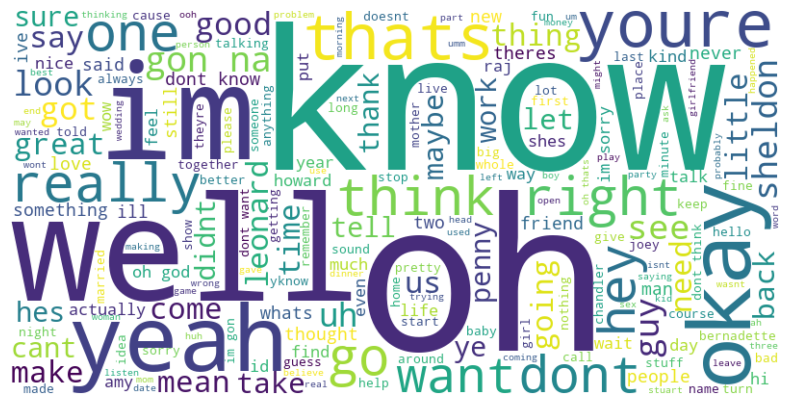

                Cleaned_SENTENCE  Sentiment
0  well im sure uh lot questions     0.5267
1                                    0.0000
2      name ron met prayer group     0.0000
3                  long involved     0.0000
4                         months     0.0000


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt




df = pd.read_csv("mustard++_text.csv")
sentences = df["SENTENCE"].dropna()

stop_words = set(stopwords.words("english"))
punctuation = string.punctuation

def preprocess_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in punctuation])
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df["Cleaned_SENTENCE"] = sentences.apply(preprocess_text)
df.head()

all_words = " ".join(df["Cleaned_SENTENCE"]).split()
word_counts = Counter(all_words)
print("Most Common Words:", word_counts.most_common(10))

df["Sentence_Length"] = df["Cleaned_SENTENCE"].apply(lambda x: len(x.split()))
print(df["Sentence_Length"].describe())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df["Cleaned_SENTENCE"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [5]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Load the CSV file and filter columns
df = pd.read_csv("data.csv", usecols=["SENTENCE", "Sarcasm"])

# Convert 'Sarcasm' to an integer binary label
df['Sarcasm'] = df['Sarcasm'].astype(int)

# Prepare the text data
sentences = df['SENTENCE'].values
labels = df['Sarcasm'].values

# Tokenization
max_words = 1000  # Maximum number of unique words
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

# Padding sequences
max_length = 20  # Set maximum length for padding
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model.add(SimpleRNN(256, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=8, validation_split=0.2,verbose=True)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4827 - loss: 0.7080 - val_accuracy: 0.5026 - val_loss: 0.7233
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4952 - loss: 0.7456 - val_accuracy: 0.4922 - val_loss: 0.7252
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5208 - loss: 0.7044 - val_accuracy: 0.4974 - val_loss: 0.7568
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4700 - loss: 0.7561 - val_accuracy: 0.5026 - val_loss: 0.7075
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4959 - loss: 0.7086 - val_accuracy: 0.4974 - val_loss: 0.6941
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5040 - loss: 0.7056 - val_accuracy: 0.4870 - val_loss: 0.6981
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4798 - loss: 0.7020 - val_accuracy: 0.4974 - val_loss: 0.7056
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4792 - loss: 0.6990 - val_accuracy: 0.5026 - v

In [ ]:
import os
import moviepy.editor as mp
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define paths
video_folder = 'final_utterance_videos'  # Change this to your video folder path
output_audio_folder = 'audio_utterance'  # Folder to save audio files
os.makedirs(output_audio_folder, exist_ok=True)  # Create output folder if it doesn't exist

# Step 2: Extract audio from videos
for video_file in os.listdir(video_folder):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(video_folder, video_file)
        audio_path = os.path.join(output_audio_folder, video_file.replace('.mp4', '.wav'))

        # Load video and extract audio
        video = mp.VideoFileClip(video_path)
        video.audio.write_audiofile(audio_path,verbose=False)

print("done h bhai")

C:\Users\DELL\AppData\Local\Temp\ipykernel_6248\2069151691.py:11: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  min_length = min(librosa.get_duration(filename=os.path.join(audio_folder, file)) for file in audio_files)


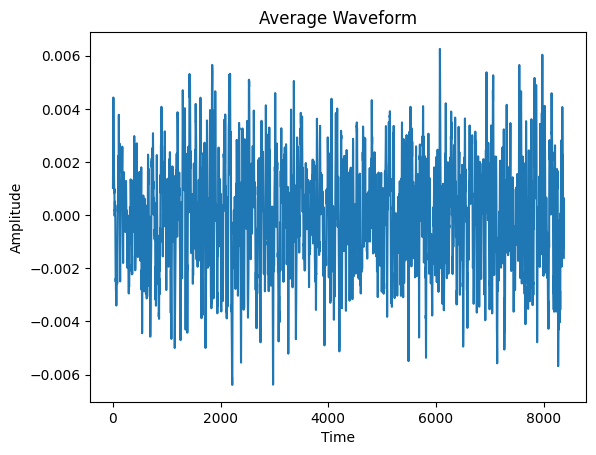

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Define the path to your audio dataset
audio_folder = 'audio_utterance'
# Find the minimum length across all audio files
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
min_length = min(librosa.get_duration(filename=os.path.join(audio_folder, file)) for file in audio_files)
sr=22050
min_samples = int(min_length * sr)  # Convert duration to number of samples based on sample rate

avg_waveform = np.zeros(min_samples)

# Process each file and truncate or pad to match the minimum length
for file in audio_files:
    y, sr = librosa.load(os.path.join(audio_folder, file), sr=None)
    
    # Truncate to the minimum length
    if len(y) > min_samples:
        y = y[:min_samples]
    else:
        y = np.pad(y, (0, max(0, min_samples - len(y))), 'constant')
        
    avg_waveform += y

# Calculate the average waveform
avg_waveform /= len(audio_files)

# Plot the average waveform
plt.figure()
plt.plot(avg_waveform)
plt.title("Average Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


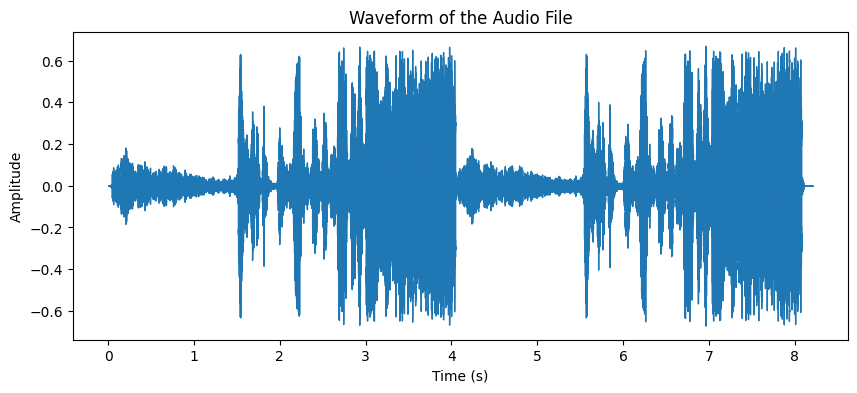

In [7]:

file_path="audio_utterance/1_60_u.wav"
y, sr = librosa.load(file_path, sr=None)  # sr=None keeps the original sample rate

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of the Audio File")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()
